In [ ]:
!pip install import_ipynb
!pip install underthesea
!pip install Lib3
!pip install demoji
!pip install pyvi
!pip install spacy
!pip install scattertext
!pip install https://gitlab.com/trungtv/vi_spacy/-/raw/master/vi_core_news_lg/dist/vi_core_news_lg-0.0.1.tar.gz

  Using cached spacy-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached blis-1.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
  Using cached thinc-8.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached thinc-8.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached statsmodels-0.14.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
  Using cached sta

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS

In [ ]:
import spacy
import scattertext as st

In [23]:
df = pd.read_excel('/content/drive/MyDrive/foody1 (1).xlsx', index_col=None)
df = df.drop(df.columns[2], axis=1)
df.head()

,review_text,rating
0,"Gà tắm mắm, phô mai kéo sợi siêu ngon, giá mềm",10.0
1,"Gà BBQ Hàn, phô mai kéo sợi siêu ngon, giá mềm",10.0
2,Gà với khoai tây quá mặn,1.0
3,Mình vừa đặt 1 phần gà 92k và vô cùng thất vọn...,4.2
4,"Đồ ăn chuẩn vị hàn quốc, ngon giá cả hợp lí",9.2


In [24]:
df.shape

(33632, 2)

In [25]:
df.isnull().sum()

,0
review_text,0
rating,0


In [26]:
df.duplicated().sum()

2098

In [27]:
df = df.drop_duplicates()
df.shape

(31534, 2)

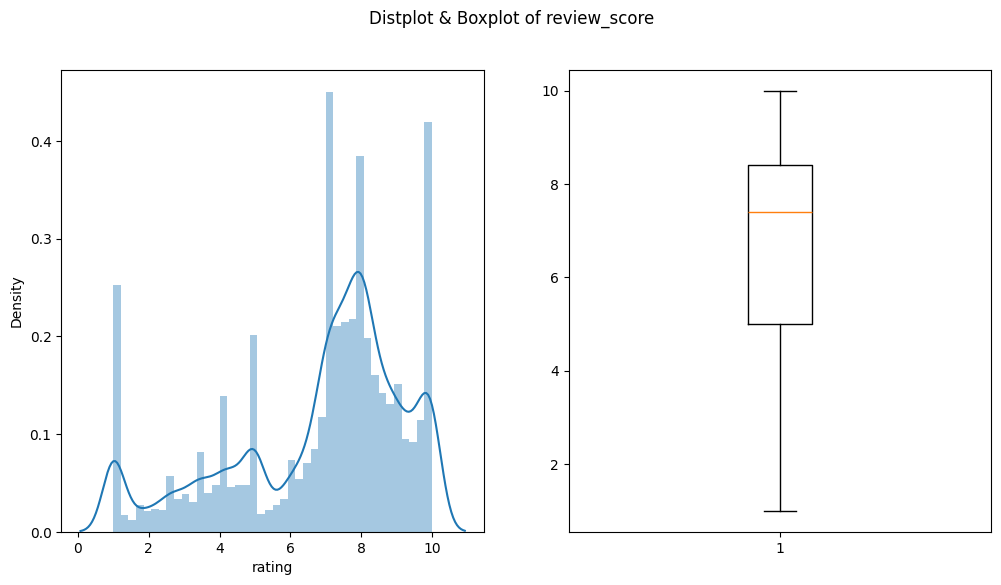

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df.rating)
plt.subplot(1,2,2)
plt.boxplot(df.rating)
plt.suptitle('Distplot & Boxplot of review_score')
plt.show()

Nhận xét:

- Score range từ 0 đến 10, phổ biến nhất là từ 6-10
- Biến Score không có outliers

In [29]:
my_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
df['rating_bins'] = pd.cut(df['rating'], bins=my_bins)

rating_bins
(7, 8]     8269
(8, 9]     5290
(9, 10]    4868
(6, 7]     3919
(4, 5]     2943
(3, 4]     1652
(0, 1]     1614
(2, 3]     1185
(5, 6]     1175
(1, 2]      619
dtype: int64


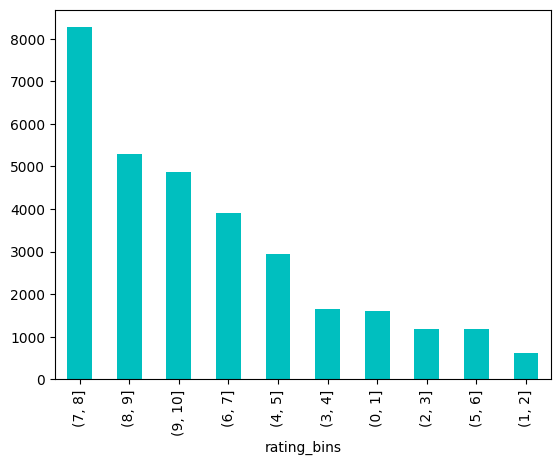

In [30]:
count = df.groupby('rating_bins').size().sort_values(ascending=False)
count.plot.bar(color='c')
print(count)
plt.show()

Nhận xét:

- Có thể thấy phần lớn điểm số thuộc khoảng (6,10], hầu hết các review đều đánh giá khá tốt, trong khi đó chỉ 1 số ít review đánh giá nhà hàng ở mức trung bình (5) và thấp
- Ta sẽ chia dữ liệu thành 2 class: 0 - Chưa Tốt (NotLike), 1 - Tốt (Like)

In [31]:
df['label'] = df.rating.apply(lambda x: 0 if x<=5 else 1)

In [32]:
df['review_class'] = ['positive' if x==1 else 'negative' for x in df.label]

label
1    23521
0     8013
Name: count, dtype: int64


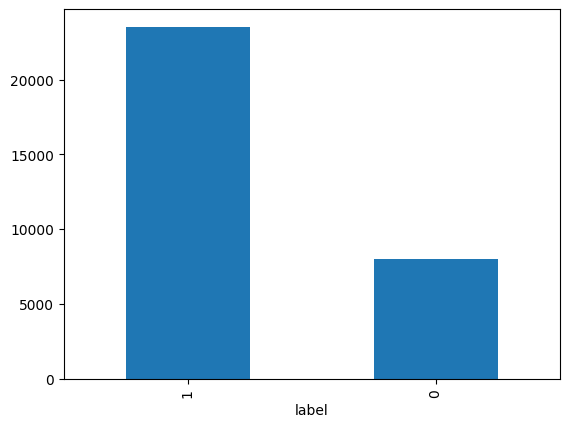

In [33]:
count = df['label'].value_counts()
count.plot.bar()
print(count)
plt.show()

Dữ liệu không cân bằng

In [ ]:
nlp = spacy.load('vi_core_news_lg')

In [ ]:
# Creating Scattertext Corpus
corpus = st.CorpusFromPandas(df, category_col='review_class',
                             text_col='comment',
                             nlp=nlp).build()

In [ ]:
# Creating the visualization
sent = st.produce_scattertext_explorer(corpus,
                                       category='negative',
                                       category_name='Negative',
                                       not_category_name='Positive',
                                       width_in_pixels=1000,
                                       metadata=df['comment']
                                       )

In [ ]:
open('Foody_Sentiment_ScatterText.html', 'wb').write(sent.encode('utf-8'))

In [ ]:
import pickle
with open('foody_corpus.pkl', mode='wb') as pkl:
  pickle.dump(corpus, pkl)

In [ ]:
#LOAD EMOJICON
file = open('/content/drive/MyDrive/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()

#LOAD TEENCODE
file = open('/content/drive/MyDrive/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('/content/drive/MyDrive/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()

#LOAD wrong words
file = open('/content/drive/MyDrive/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()

#LOAD STOPWORDS
file = open('/content/drive/MyDrive/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [ ]:
def clean_text(text, emoji_lst, teen_lst, english_lst, wrong_lst, stopwords_lst):
    # Remove emojis
    for emoji in emoji_lst:
        text = text.replace(emoji, '')

    # Remove teen code
    for word in teen_lst:
        text = re.sub(r'\b' + re.escape(word) + r'\b', '', text)

    # Remove English-Vietnamese slang
    for word in english_lst:
        text = re.sub(r'\b' + re.escape(word) + r'\b', '', text)

    # Remove wrong words
    for word in wrong_lst:
        text = re.sub(r'\b' + re.escape(word) + r'\b', '', text)

    # Remove Vietnamese stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords_lst])

    return text

In [ ]:
import re
df['review_text_clean'] = df['comment'].apply(lambda x: clean_text(x, emoji_lst, teen_lst, english_lst, wrong_lst, stopwords_lst))

In [40]:
df[['review_text','review_text_clean']]

,review_text,review_text_clean
0,"Gà tắm mắm, phô mai kéo sợi siêu ngon, giá mềm",gà tắm mắm phô mai kéo sợi siêu ngon giá mềm
1,"Gà BBQ Hàn, phô mai kéo sợi siêu ngon, giá mềm",gà bq hàn phô mai kéo sợi siêu ngon giá mềm
2,Gà với khoai tây quá mặn,gà với khoai tây quá mặn
3,Mình vừa đặt 1 phần gà 92k và vô cùng thất vọn...,mình vừa đặt 1 phần gà 92k và vô cùng thất vọn...
4,"Đồ ăn chuẩn vị hàn quốc, ngon giá cả hợp lí",đồ ăn chuẩn vị hàn quốc ngon giá cả hợp lí
...,...,...
33627,"Bánh canh ngon, ăn ko ngán, bánh lọc thì tuyệt...",bánh canh ngon ăn không ngán bánh lọc thì tu...
33628,"Được người bạn giới thiệu vào đây, các bạn có ...",được người bạn giới thiệu vào đây các bạn có ...
33629,"Quán nằm trong đường Trần Quang Diệu, mà phải ...",quán nằm trong đường trần quang diệu mà phải ...
33630,"Trời mưa lạnh thèm ăn bún bò, lần đầu lại đây ...",trời mưa lạnh thèm ăn bún bò lần đầu lại đây ...


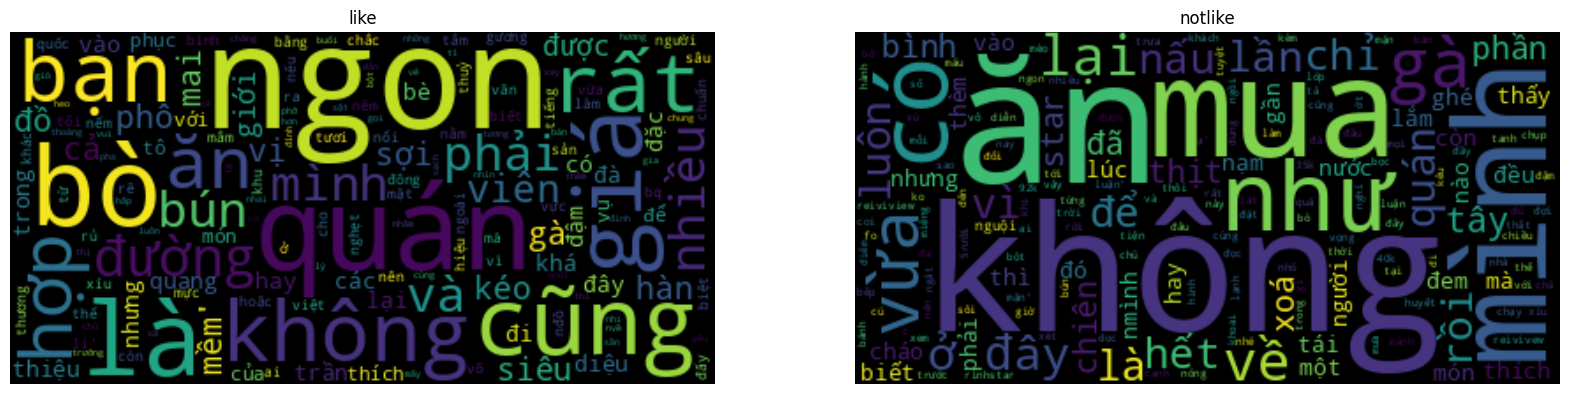

In [41]:
# Vẽ wordcloud để xem những từ phổ biến ở mỗi class
# Like - Class 1
wc_like = WordCloud(
    background_color='black',
    max_words=1000)
wc_like.generate(str(df[df['label']==1]['review_text_clean'].values))

# Not Like
wc_notlike = WordCloud(
    background_color='black',
    max_words=1000)
wc_notlike.generate(str(df[df['label']==0]['review_text_clean'].values))

# display the word clouds
plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.imshow(wc_like, interpolation='bilinear')
plt.title('like')
plt.axis('off')
plt.subplot(122)
plt.imshow(wc_notlike, interpolation='bilinear')
plt.title('notlike')
plt.axis('off')
plt.show()

In [42]:
df.to_excel('food_review_clean.xlsx', index=False)